# Vehicle Classification from Images using Deep CNNs and Transfer Learning
> <span style="color:gray">
Final assignment in [DTU Deep Learning](https://github.com/sleire/02456-deep-learning_spes) by 
 [Anders D. Sleire](mailto:anders.sleire@uib.no)
</span>


In this notebook we modify deep pre-trained convolutional neural networks via transfer learning to build fine-grained classifiers able to identify vechicle make and model for the stanford cars data. We also train a simple model from scrathch for benchmarking. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import numpy as np
import tensorflow as tf
import os, sys, random , glob, math
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
from sklearn.metrics import confusion_matrix
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


## The Stanford Cars Data

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.  
Source: [http://ai.stanford.edu/~jkrause/cars/car_dataset.html](http://ai.stanford.edu/~jkrause/cars/car_dataset.html)

Some random images from the cars dataset


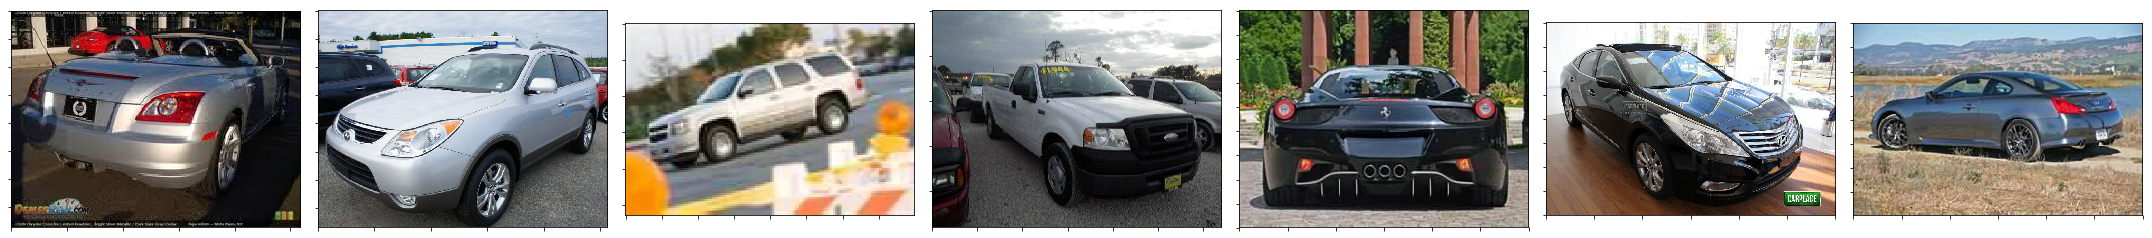

In [2]:
n = 7
folder = '..\\stanford_cars\\car_ims'

fig, ax = plt.subplots(1,n,figsize=(30,30))
print("Some random images from the cars dataset")
for i in range(n):
    a = random.choice(os.listdir(folder))
    im = Image.open(folder + '\\' + a)
    ax[i].imshow(np.asarray(im))
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())
plt.tight_layout()
plt.show()

In [3]:
# import dictionary with annotations and class names
cars_annos = scipy.io.loadmat('cars_annos.mat')
cars_annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

The annotations provide coordinates for bounding boxes, class labels, and assignment to train/ test

In [4]:
# clean up and convert annotations to dataframe
df_cars = pd.DataFrame(cars_annos['annotations'][0])

In [5]:
for coln in df_cars.columns[1:].tolist():
    df_cars[coln] = [i[0][0] for i in df_cars[coln]]

df_cars['relative_im_path'] = [i[0] for i in df_cars['relative_im_path']]

In [6]:
df_cars.head()

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [7]:
# for each car class, move five first observations from train and test to a new validation category (label = 2 in test column)
class_idx = df_cars['class'].unique().tolist()

for cl in class_idx:
    t0 = list(df_cars[(df_cars['class']==cl)&(df_cars['test']==0)].index.tolist()[:5])
    t1 = list(df_cars[(df_cars['class']==cl)&(df_cars['test']==1)].index.tolist()[:5])
    for ii in t0+t1:
        df_cars.at[ii, 'test'] = 2

In [8]:
# display the new dataframe with new value = 2 for validation data in the 'test' column
df_cars.head(10)

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,2
1,car_ims/000002.jpg,48,24,441,202,1,2
2,car_ims/000003.jpg,7,4,277,180,1,2
3,car_ims/000004.jpg,33,50,197,150,1,2
4,car_ims/000005.jpg,5,8,83,58,1,2
5,car_ims/000006.jpg,10,6,250,110,1,0
6,car_ims/000007.jpg,56,1,394,176,1,0
7,car_ims/000008.jpg,1,13,113,83,1,0
8,car_ims/000009.jpg,15,111,271,272,1,0
9,car_ims/000010.jpg,14,18,148,107,1,0


In [9]:
# create list with the 196 class names (model, make, year)
class_names = list()
for l in cars_annos['class_names'][0]:
    class_names.append(l[0])

# create list with labels for all images
label = list()
for i in range(16185):
    k = cars_annos['annotations'][0][i][5][0][0]
    label.append(class_names[k-1])

Original and cropped version of car_ims/013395.jpg showing the Mercedes-Benz SL-Class Coupe 2009


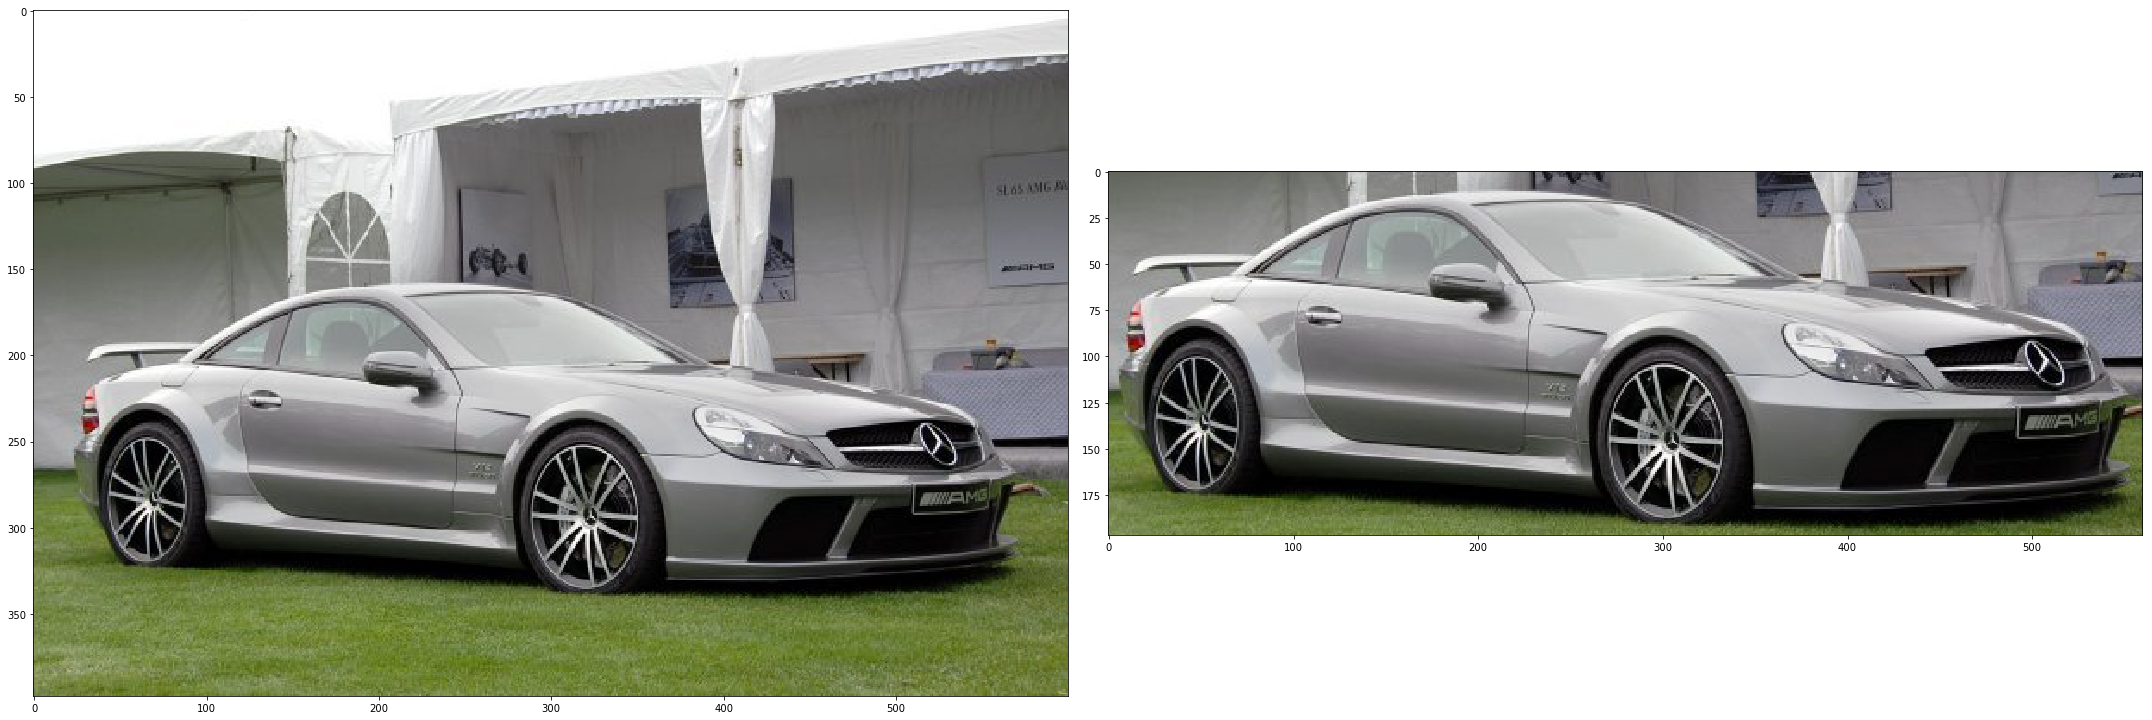

In [11]:
# display a random image (original and cropped with bounding box)
a = random.randint(0, 16184)
image = cars_annos['annotations'][0][a][0][0]
x1 = cars_annos['annotations'][0][a][1][0][0]
y1 = cars_annos['annotations'][0][a][2][0][0]
x2 = cars_annos['annotations'][0][a][3][0][0]
y2 = cars_annos['annotations'][0][a][4][0][0]

print('Original and cropped version of ' + image + ' showing the ' + label[a])
fig, ax = plt.subplots(1,2,figsize=(30,30))
im = Image.open('..\\stanford_cars\\' + image)
ax[0].imshow(np.asarray(im))
ax[1].imshow(np.asarray(im.crop((x1, y1, x2, y2))))
plt.tight_layout()
plt.show()

## Structure the data in folders for modelling in keras

In [23]:
# create test folder, then train and validation folders with subfolders for each class
os.makedirs('test')

for subfolder_name in class_names:
    os.makedirs(os.path.join('train', subfolder_name))
    os.makedirs(os.path.join('validation', subfolder_name))

In [12]:
# define list with train, test validation groups to be used when storing cropped files below
group = ['train', 'test', 'validation']

In [25]:
# crop all images in the data set based on bounding boxes and store in train, validation and test folders
for i in range(16185):
    image = '..\\stanford_cars\\' + cars_annos['annotations'][0][i][0][0]
    im_name = df_cars.ix[i, 'relative_im_path'][8:]
    x1 = df_cars.ix[i,'bbox_x1']
    y1 = df_cars.ix[i,'bbox_y1']
    x2 = df_cars.ix[i,'bbox_x2']
    y2 = df_cars.ix[i,'bbox_y2']
    group_idx = df_cars.ix[i, 'test']
    im = Image.open(image)
    im = im.crop((x1, y1, x2, y2))
    # put all test images in one single folder
    if group_idx == 1:
        im.save('..\\stanford_cars\\' + group[group_idx] + '\\crop_' + im_name)
    else:
        im.save('..\\stanford_cars\\' + group[group_idx] + '\\' + label[i] + '\\crop_' + im_name)

In [13]:
# dimensions of our images.  
img_width, img_height = 224, 224  

#top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'

# number of epochs to train top model  
epochs = 50  

# batch size used by flow_from_directory and predict_generator  
batch_size = 16 

## Functions for training

In [12]:
def bottleneck_features(model, mod_name):
    
    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(generator, predict_size_train)
    
    train_save_name = mod_name + '_' + 'bottleneck_features_train.npy'

    np.save(train_save_name, bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(generator, predict_size_validation)
    
    validation_save_name = mod_name + '_' + 'bottleneck_features_validation.npy'

    np.save(validation_save_name, bottleneck_features_validation)

In [13]:
def train_top_model(train_data, validation_data, top_model_weights_path):
    
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_labels = generator_top.classes
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("Loss: {}".format(eval_loss))
    
    # summarize history for accuracy and loss
    plt.figure(1, figsize=(18, 6))

    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [14]:
def classify(model, class_dictionary, top_model_weights_path, image_path):

    num_classes = len(class_dictionary)
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255
    image = np.expand_dims(image, axis=0)

    # get the bottleneck prediction from the pre-trained model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.load_weights(top_model_weights_path)

    # use bottleneck prediction on the top model to get final classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]
    
    # return class index only
    #return(inID)

    inv_map = {v: k for k, v in class_dictionary.items()}
    label = inv_map[inID]
    
    # return class index only
    return(label)
    # get the prediction label
    #print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    

### Modelling strategy: For each of the selected imagenet models
1. Save bottleneck features to be used as training data for top model
2. Train top model (predict and evaluate on test data)
3. Add trained top model to imagenet model and fine tune (predict and evaluate on test data)

In [14]:
# list of test files to pass to classify function
test_files = glob.glob(test_data_dir + "/*.*")

In [17]:
# create list of true labels for the test files

ims = []
for file in test_files:
    ims.append('car_ims/' + file[-10:])

actual_idx = df_cars[df_cars['relative_im_path'].isin(ims)]['class'].tolist()

actual = []
for i in actual_idx:
    actual.append(class_names[i-1])

## VGG16 model

1). Save bottleneck features to be used as training data for top model

In [17]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

bottleneck_features(model = vgg16, mod_name = 'vgg16')

Found 169 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


2). Train top model (predict and evaluate on test data)

Found 169 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
50/50 [==============================] - 0s 680us/step
Accuracy: 94.00%
Loss: 0.4101360046863556


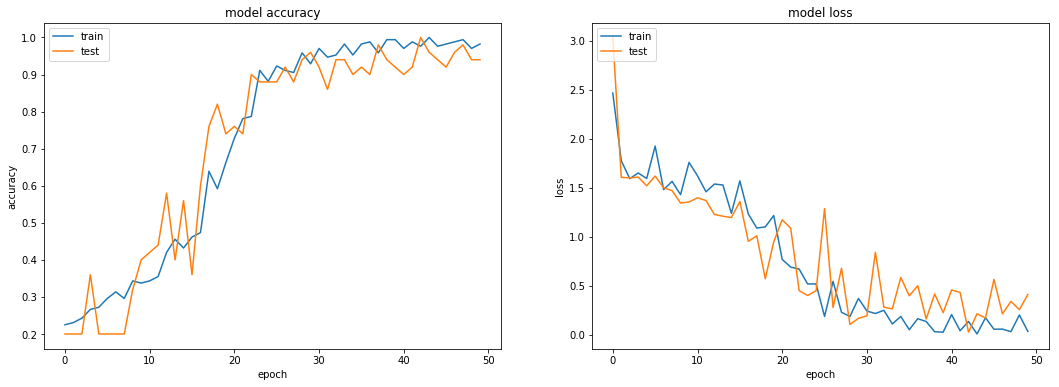

In [26]:
train_data = np.load('vgg16_bottleneck_features_train.npy')
validation_data = np.load('vgg16_bottleneck_features_validation.npy')
top_model_weights_path = 'vgg16_bottleneck_fc_model.h5'

# train the top model with bottleneck features from above
train_top_model(train_data, validation_data, top_model_weights_path)

In [82]:
# classify cars in test images
model = applications.VGG16(include_top=False, weights='imagenet')
class_dictionary = np.load('class_indices.npy').item()
top_model_weights_path = 'vgg16_bottleneck_fc_model.h5'

predict = []
for file in test_files:
    image_path = file
    predict.append(classify(model, class_dictionary, top_model_weights_path, image_path))

1/1 [==============================] - 0s 0us/step


In [140]:
# confusion matrix
m = confusion_matrix(actual, predict)
print(m)

[[39  0  0  0  0]
 [ 1 31  0  3  0]
 [ 0  4 23  1  2]
 [ 0  1  0 33  0]
 [ 0  0  0  0 27]]


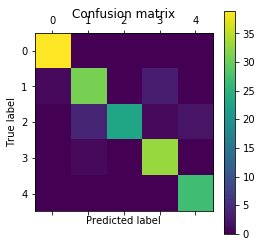

In [143]:
# plot confusion matrix
plt.matshow(m)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

3). Add trained top model to imagenet model and fine tune (predict and evaluate on test data)

## VGG19 model

1). Save bottleneck features to be used as training data for top model

In [16]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet')

bottleneck_features(model = vgg19, mod_name = 'vgg19')

2). Train top model (predict and evaluate on test data)

Found 169 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
50/50 [==============================] - 0s 50us/step
Accuracy: 88.00%
Loss: 0.3531804263591766


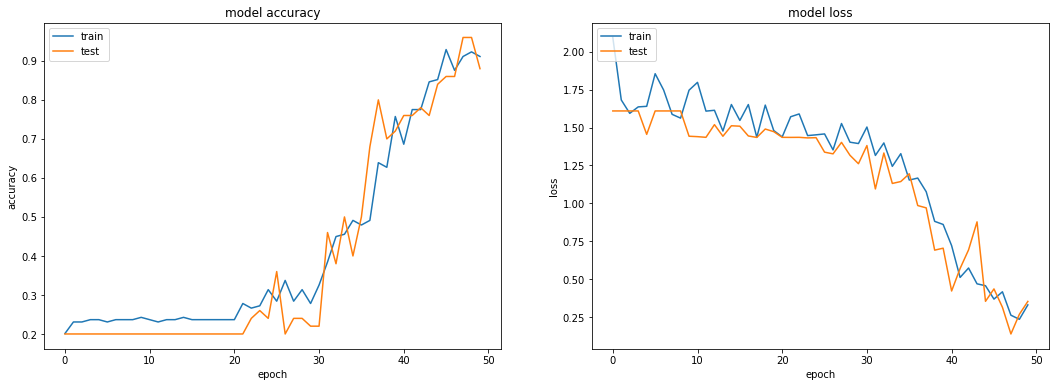

In [18]:
train_data = np.load('vgg19_bottleneck_features_train.npy')
validation_data = np.load('vgg19_bottleneck_features_validation.npy')
top_model_weights_path = 'vgg19_bottleneck_fc_model.h5'

# train the top model with bottleneck features from above
train_top_model(train_data, validation_data, top_model_weights_path)

In [21]:
# classify cars in test images
model = applications.VGG19(include_top=False, weights='imagenet')
class_dictionary = np.load('class_indices.npy').item()
top_model_weights_path = 'vgg19_bottleneck_fc_model.h5'

predict = []
for file in test_files:
    image_path = file
    predict.append(classify(model, class_dictionary, top_model_weights_path, image_path))

1/1 [==============================] - 0s 0us/step


In [25]:
# confusion matrix
m = confusion_matrix(actual, predict)
print(m)

[[39  0  0  0  0]
 [ 2 30  3  0  0]
 [ 0  0 30  0  0]
 [ 0  3  8 23  0]
 [ 1  0  1  0 25]]


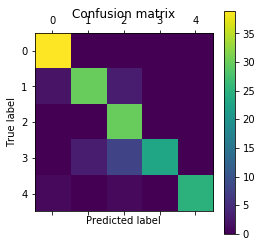

In [26]:
# plot confusion matrix
plt.matshow(m)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## ResNet50 model

1). Save bottleneck features to be used as training data for top model

In [29]:
# import pre trained ResNet50 model from Keras applications
resnet50 = applications.ResNet50(include_top=False, weights='imagenet')

bottleneck_features(model = resnet50, mod_name = 'resnet50')

Found 169 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


2). Train top model (predict and evaluate on test data)

Found 169 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
50/50 [==============================] - 0s 312us/step
Accuracy: 46.00%
Loss: 1.3342884635925294


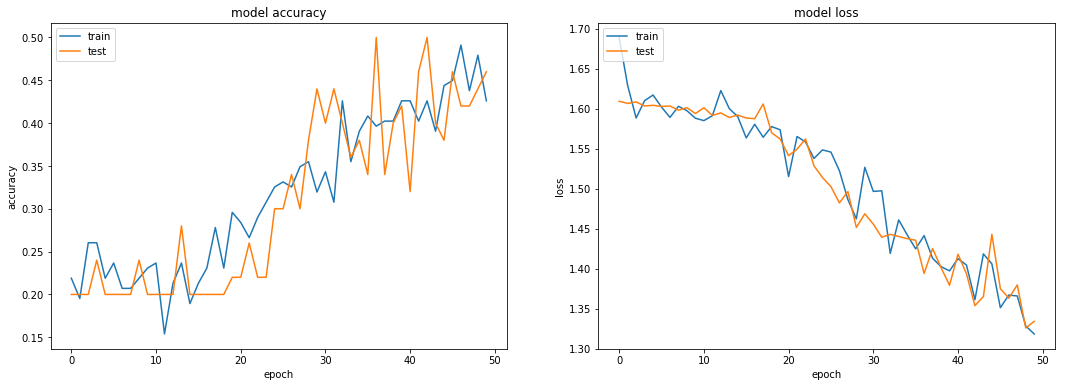

In [31]:
train_data = np.load('resnet50_bottleneck_features_train.npy')
validation_data = np.load('resnet50_bottleneck_features_validation.npy')
top_model_weights_path = 'resnet50_bottleneck_fc_model.h5'

# train the top model with bottleneck features from above
train_top_model(train_data, validation_data, top_model_weights_path)

In [33]:
# classify cars in test images
model = applications.ResNet50(include_top=False, weights='imagenet')
class_dictionary = np.load('class_indices.npy').item()
top_model_weights_path = 'resnet50_bottleneck_fc_model.h5'

predict = []
for file in test_files:
    image_path = file
    predict.append(classify(model, class_dictionary, top_model_weights_path, image_path))

1/1 [==============================] - 0s 0us/step


In [34]:
# confusion matrix
m = confusion_matrix(actual, predict)
print(m)

[[15 17  0  2  5]
 [ 0 30  1  0  4]
 [ 0 14  6  1  9]
 [ 0 20  4  0 10]
 [ 1  4  0  0 22]]


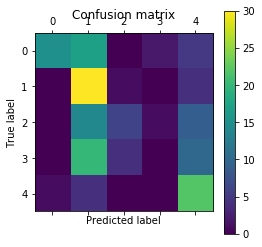

In [35]:
# plot confusion matrix
plt.matshow(m)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()